# CEE 598: Uncertainty Quantification
## Assignment Four
### Noah Garfinkle (garfink2@illinois edu)
### 12 March 2020

## Imports and Setup

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import time
from ipypb import track

## References

- https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1
- https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348

## Problem 1.

Consider a modification of the famous "braking data" of Tukey (1977) given below.  Note that for some speed ($x$) values two distance ($y$) values are given and separated by a comma.  The two values are obtained from two independent experiments.  A quadratic model is to be built resulting in the following measurement equation

$$
y = a + bx + cx^2 + \epsilon
$$

where $\epsilon \sim N(0,\sigma^2 = 2^2)$.  We need to estimate the parameters $a$, $b$, and $c$ in this model in a probabilistic way.  Consider the prior density fucntions of these parameters are given as follows:

$$
a \sim \pi(a) = N(1,\sigma^2=5^2)
$$

$$
b \sim \pi(b) = N(0.2,\sigma^2=0.05^2)
$$

and

$$
c \sim \pi(c) = N(0.2,\sigma^2=0.05^2)
$$

Use your Metropolis-Hastings code to generate the posterior histograms of these three parameters, using 10,000 posterior samples.  You can choose the proposal however you like.  Discuss:

- Your choice of proposal,
- It's impact on the outcome,
- The convergence property,
- Acceptance rates, and
- Other interesting points about your results

Methodology

- Generate random pulls of a,b,c
- Use those to calculate y for a breaking value and compare to the actual
- Center the error function on y and use that to estimate the liklihood
- Use the liklihood as part of the MCMC acceptance criteria
- Instead of having one accepted argument, I will have three (a,b,c)

In [2]:
xs_init = [4,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25]
ys_1 = [2,4,16,10,18,17,14,26,26,20,32,32,42,36,32,66,54,70,85]
ys_2 = [10,22,None,None,26,28,20,34,36,26,40,40,56,46,48,None,None,92,None]
df_prob1_2col = pd.DataFrame({"x":xs_init,"y1":ys_1,"y2":ys_2})

In [3]:
xs = []
ys = []
for i,row in df_prob1_2col.iterrows():
    xs.append(row["x"])
    ys.append(row["y1"])
    if not row.isna()["y2"]:
        xs.append(row["x"])
        ys.append(row["y2"])
df_prob1 = pd.DataFrame({"x":xs,"y":ys})

Text(0, 0.5, '$y$ = distance to stop (feet)')

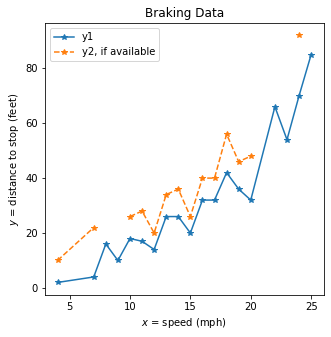

In [4]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(xs_init,ys_1,label="y1",marker="*")
ax.plot(xs_init,ys_2,label="y2, if available",marker="*",ls="--")
ax.legend()
ax.set_title("Braking Data")
ax.set_xlabel("$x$ = speed (mph)")
ax.set_ylabel("$y$ = distance to stop (feet)")

In [5]:
def π_normal(x,σ):
    normalDist = stats.norm(loc=x,scale=σ)
    proposedValue = normalDist.rvs()
    return proposedValue

In [8]:
def π_PDF(a,b,c,mean=[1,0.2,0.2],cov=np.diag([5,0.05,0.05])):
    normalDist = stats.multivariate_normal(mean=mean,cov=cov)
    p = normalDist.pdf([a,b,c])
    return p

In [9]:
def predict_y(x,a,b,c,ϵ):
    y = a + b * x + c * x * x + ϵ
    return y

In [10]:
# liklihood function
def f_errorCheck(x,σ,a,b,c,yActual):
    prediction = predict_y(x,a,b,c,0.0)
    errorDist = stats.norm(loc=prediction,scale=σ)
    p = errorDist.pdf(yActual)
    return p

In [11]:
# I think what actually needs to happen here with my proposal is a normal distribution centered on x and with σ
def q_x(x,σ):
    normalDist = stats.norm(loc=x,scale=σ)
    proposedValue = normalDist.rvs()
    return proposedValue

In [14]:
def likelihood(observations,estimatedValues,σ):
    left = 1 / (np.power(2*np.pi*σ*σ,len(observations)/2))
    SS = 0.0
    for i in range(0,len(observations)):
        observation = observations[i]
        estimatedValue = estimatedValues[i]
        SS += np.power(observation-estimatedValue,2)
    right = np.exp(-SS/(2*σ*σ))
    l = left * right
    return l

Office hours
- Propose new candidate for a,b,c
- Plug into equation and get y
- Center noise distribution onto y and calculate probability that you get the observation
- This gives the density value which represents the liklihood for the data
- Do the same thing for all data points, calculating y(x) given a,b,c
- The final liklihood is the multiplication of the liklihoods
-- Floating point precision error for very small liklihoods.  Instead of calculating the liklihood, calculate the log liklihood.
---The log of the overall liklihood is equal to the log of each term, added together.
---- Calculate the liklihood of each data point, take the log of each, and sum.  This is the only term so far.
- Now we need decide if we accept/reject.  Alpha is the prior of the candidate times the liklihood of the candidate times the prior of the previous accepted / liklihood of previous accepted.
-- We need to take the log of this as well: $log(\alpha)=log(prior proposed)+log(liklihood of proposed) - log(prior of previous accepted) - log(liklihood of previous accepted)$ # prior will cancel out in uniform distribution
--- For normal, assume a,b,c are independent, plug in a,b,c, for each of them we plug in the into the density and find corresponding density value.  For the normal, we just need to know the probability of getting value of a,b,c based on their distributions.  Because we are doing log of prior, the log is the summation of the log value of the densities
--- The priors cancel out for uniform, so it simplifies to log(\alpha) = log(liklihood of proposed) - log(liklihood of previous accepted)
---- Convert back to alpha and draw a random number
- MH gives samples
- Bayes: have an equation of acceptance probability

In [7]:
# This function generates the random numbers for the parameters being tested
def π(mean=[1,0.2,0.2],cov=np.diag([5,0.05,0.05])):
    normalDist = stats.multivariate_normal(mean=mean,cov=cov)
    proposedValues = normalDist.rvs()
    return proposedValues

In [18]:
# This function calculates the probability that the parameters are pulled from their distribution
def π_Prior(a,b,c,mean=[1,0.2,0.2],cov=np.diag([5,0.05,0.05])):
    normalDist = stats.multivariate_normal(mean=mean,cov=cov)
    p = normalDist.pdf([a,b,c])
    return p

In [35]:
# This function calculates the liklihood (non-log) of an indvidual observation
def π_Liklihood(observation,x,a,b,c,σ=2.0):
    prediction = predict_y(x,a,b,c,0.0)
    errorDist = stats.norm(loc=prediction,scale=σ)
    p = errorDist.pdf(observation)
    return p

In [36]:
# This function loops through a set of observations and calculates the log liklihood of each, summed
def π_Log_Liklihood(observations,xs,a,b,c):
    logLiklihood = 0.0
    for i,observation in enumerate(observations):
        x = xs[i]
        logLiklihood += np.log(π_Liklihood(observation,x,a,b,c))
    return logLiklihood

In [118]:
n = 100000
σ = 2
proposalCov = np.diag([20,0.2,0.2])
a,b,c = π(cov=proposalCov)
iterations = []
a_s = []
b_s = []
c_s = []
proposedAs = []
proposedBs = []
proposedCs = []
arr_Accepted = []
acceptanceRatios = []

xs = list(df_prob1.x)
ys = list(df_prob1.y)

for t in track(range(0,n)):
    # obtain a proposed value from q
    proposed_a,proposed_b,proposed_c = π(cov=proposalCov)
    
    # calculate the acceptance probability
    α = np.exp(np.log(π_Prior(proposed_a,proposed_b,proposed_c)) + π_Log_Liklihood(ys,xs,proposed_a,proposed_b,proposed_c) - np.log(π_Prior(a,b,c)) - π_Log_Liklihood(ys,xs,a,b,c))
   
    α = min(1,α)
    acceptanceRatios.append(α)
    accepted = False
    
    if α == 1: #accept
        a = proposed_a
        b = proposed_b
        c = proposed_c
        accepted = True
    else: # draw a random number and take the probability from acceptanceRatio
        rand = np.random.random()
        if rand < α:
            a = proposed_a
            b = proposed_b
            c = proposed_c
            accepted = True
        else:
            pass
    iterations.append(t)
    a_s.append(a)
    b_s.append(b)
    c_s.append(c)
    proposedAs.append(proposed_a)
    proposedBs.append(proposed_b)
    proposedCs.append(proposed_c)
    arr_Accepted.append(accepted)
df = pd.DataFrame({"t":iterations,"a":a_s,"b":b_s,"c":c_s,"proposals_a":proposedAs,
                   "proposals_b":proposedBs,"proposals_c":proposedCs,"accepted":arr_Accepted,"acceptance ratio":acceptanceRatios})

df_Accepted = df[df["accepted"]==True]
df_Rejected = df[df["accepted"]==False]

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [119]:
print(f"{len(df_Rejected)/n*100:,.2f}% rejected")

99.98% rejected


In [120]:
print(f"a:{df['a'].mean():,.2f},b:{df['b'].mean():,.2f},c:{df['c'].mean():,.2f}")

a:5.38,b:-0.05,c:0.12


Text(0.5, 1.0, 'c')

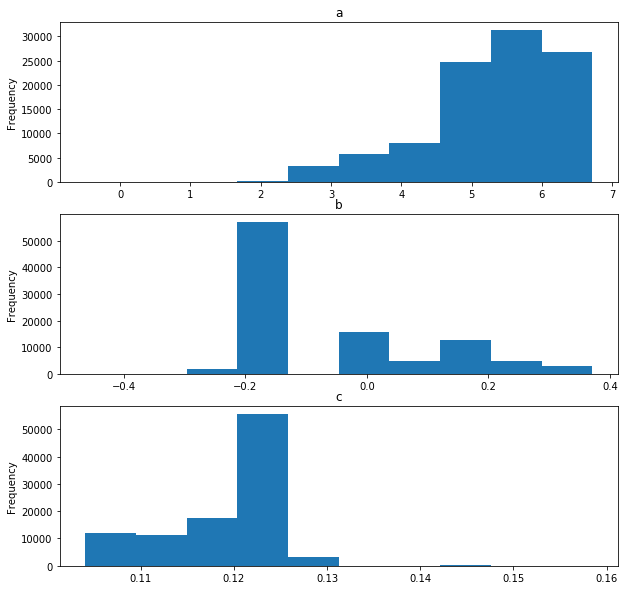

In [121]:
fig, axs = plt.subplots(3,figsize=(10,10))
df["a"].plot(kind="hist",ax=axs[0])
df["b"].plot(kind="hist",ax=axs[1])
df["c"].plot(kind="hist",ax=axs[2])
axs[0].set_title("a")
axs[1].set_title("b")
axs[2].set_title("c")

In [122]:
print(f"The fraction of candidcates accepted was {np.sum(df['accepted'])/n:,.5f}")

The fraction of candidcates accepted was 0.00021


Text(0.5, 1.0, 'Values Accepted for Each Parameter')

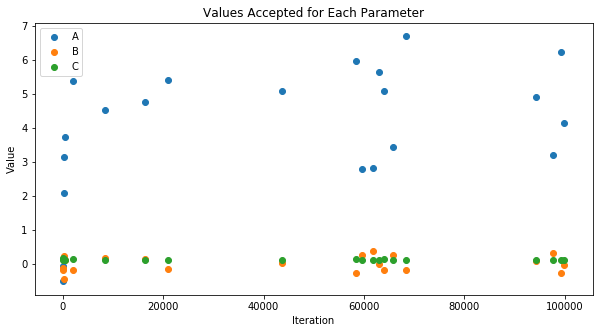

In [123]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_Accepted["t"],df_Accepted["a"],label="A")
ax.scatter(df_Accepted["t"],df_Accepted["b"],label="B")
ax.scatter(df_Accepted["t"],df_Accepted["c"],label="C")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Value")
ax.set_title("Values Accepted for Each Parameter")

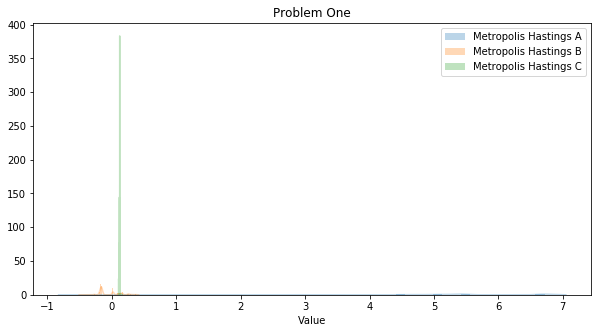

In [124]:
kwargs = {'alpha':0.3}
fig,ax = plt.subplots(figsize=(10,5))
sns.distplot(df["a"],ax=ax,label="Metropolis Hastings A",hist_kws=kwargs, kde_kws=kwargs)
sns.distplot(df["b"],ax=ax,label="Metropolis Hastings B",hist_kws=kwargs, kde_kws=kwargs)
sns.distplot(df["c"],ax=ax,label="Metropolis Hastings C",hist_kws=kwargs, kde_kws=kwargs)
ax.set_xlabel("Value")
ax.set_title("Problem One")
ax.legend()

In [125]:
predictions = [predict_y(x,df["a"].mean(),df["b"].mean(),df["c"].mean(),0.0) for x in xs]

Text(0, 0.5, '$y$ = distance to stop (feet)')

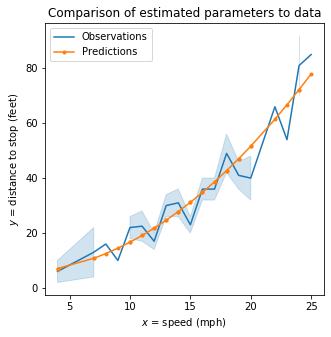

In [126]:
fig,ax = plt.subplots(figsize=(5,5))
sns.lineplot("x","y",data=df_prob1,ax=ax,label="Observations") # ,estimator=None,err_style="bars"
ax.plot(xs,predictions,label="Predictions",marker='.')
ax.legend()
ax.set_title("Comparison of estimated parameters to data")
ax.set_xlabel("$x$ = speed (mph)")
ax.set_ylabel("$y$ = distance to stop (feet)")

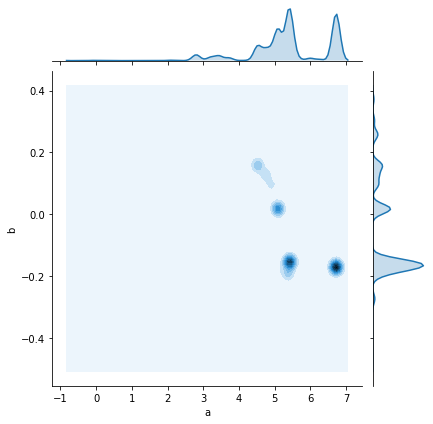

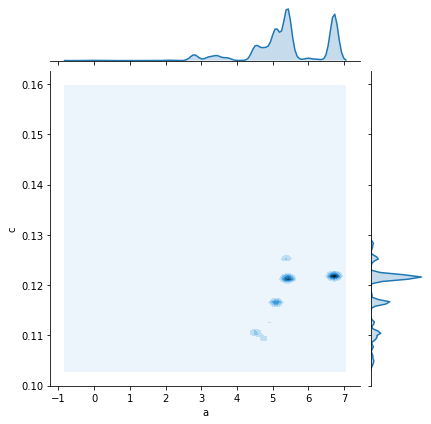

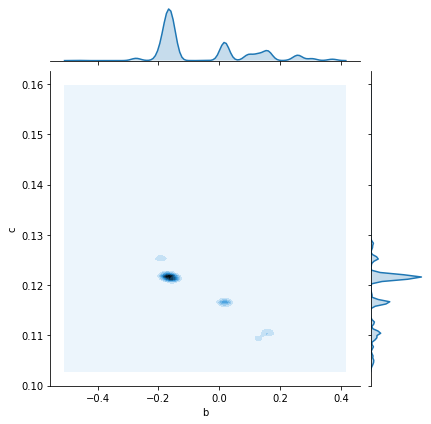

In [127]:
sns.jointplot(x="a",y="b",data=df,kind="kde")
sns.jointplot(x="a",y="c",data=df,kind="kde")
sns.jointplot(x="b",y="c",data=df,kind="kde")

Text(0, 0.5, 'Rolling Mean')

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


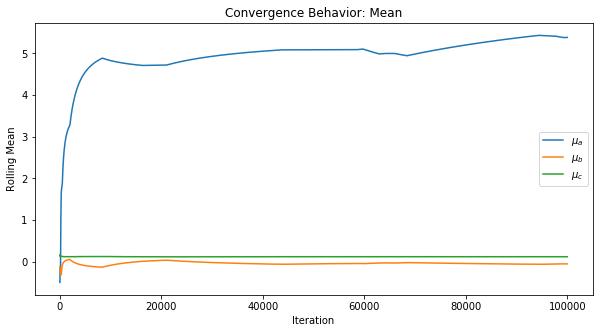

In [128]:
# Convergence behavior- mean
fig,ax = plt.subplots(figsize=(10,5))
df["a"].expanding().mean().plot(ax=ax,label="$\mu_a$")
df["b"].expanding().mean().plot(ax=ax,label="$\mu_b$")
df["c"].expanding().mean().plot(ax=ax,label="$\mu_c$")
ax.legend()
ax.set_title("Convergence Behavior: Mean")
ax.set_xlabel("Iteration")
ax.set_ylabel("Rolling Mean")

Text(0, 0.5, 'Rolling STD')

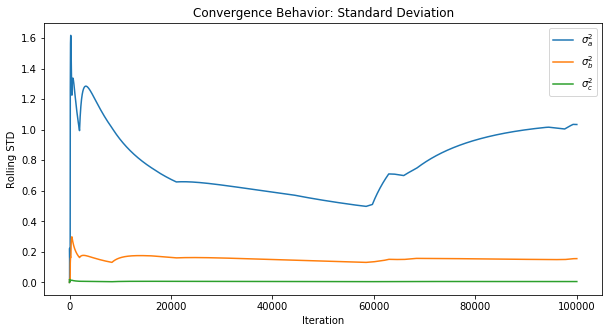

In [129]:
# Convergence behavior- standard deviation
fig,ax = plt.subplots(figsize=(10,5))
df["a"].expanding().std().plot(ax=ax,label="$\sigma^2_a$")
df["b"].expanding().std().plot(ax=ax,label="$\sigma^2_b$")
df["c"].expanding().std().plot(ax=ax,label="$\sigma^2_c$")
ax.legend()
ax.set_title("Convergence Behavior: Standard Deviation")
ax.set_xlabel("Iteration")
ax.set_ylabel("Rolling STD")

## Problem Two

You are asked to estimate the mechanical property (specifically the elastic modulus) of the material used in a set of manufactured truss members.  You have access to the experiments carried otu on a number of truss structures (as shown in the Figure) made from these elements.  Specifically, you are provided with the displacements at a number of nodes.  Assume all the truss bars have the same elastic modulus.

In order to use Bayesian inference, a structural analysis code is provided that calculates the displacements under different loadings.  The code is available in the 'Truss Analysis' folder on Piazza, together with the documentation file ('Help.pdf').  Try to get familiar with the code and its inputs and outputs, and verify that for $YM=1e7$, your outputs match those given in the documentation.

The measurement equation is as follows:

$$
y = g(E) + \epsilon
$$

where $g(E)$ is the displacement given by the model and $\epsilon \sim N(0,\sigma^2 = 0.01^2)$ is the measurement noise.

Approach:

Because I am not familiar with MATLAB, I have opted to replicate the MATLAB functions Data.m and ST.m using Python, below.

Steps to run the MATLAB code for my reference:
1. D=Data(1e7)
2. [F,U,R] = ST(D)
3. TP(D,U,20)

In [130]:
class Data:
    def __init__(self,YM):
        self.YM = YM
        self.Coord = []
        self.Con = []
        self.Re = []
        self.Load = []
        self.E = []
        self.A = []
        
        self.createCoord()
        self.createCon()
        self.createRE()
        self.createLoad()
        self.createE()
        self.createA()
        
    def createCoord(self):
        coords=np.array([-37.5,0,200,37.5,0,200,-37.5,37.5,100,37.5,37.5,100,37.5,-37.5,100,-37.5,-37.5,100,-100,100,0,100,100,0,100,-100,0,-100,-100,0])
        coords_x = []
        coords_y = []
        coords_z = []
        index = 0
        for coord in coords:
            if index == 0:
                coords_x.append(coord)
            elif index == 1:
                coords_y.append(coord)
            elif index == 2:
                coords_z.append(coord)
            else:
                print("ERROR")
            index += 1
            if index == 3:
                index = 0
        df_coords = pd.DataFrame({"x":coords_x,"y":coords_y,"z":coords_z})
        self.Coord = df_coords
        
    def createCon(self):
        Con=[1,2,1,4,2,3,1,5,2,6,2,4,2,5,1,3,1,6,3,6,4,5,3,4,5,6,3,10,6,7,4,9,5,8,4,7,3,8,5,10,6,9,6,10,3,7,4,8,5,9]
        con_starts = []
        con_ends = []
        index = 0
        for node in Con:
            if index == 0:
                con_starts.append(node)
            elif index == 1:
                con_ends.append(node)
            else:
                print("ERROR")
            index += 1
            if index == 2:
                index = 0
        df_connections = pd.DataFrame({"start":con_starts,"end":con_ends})
        self.Con = df_connections
    
    def createRE(self):
        Re = np.zeros((10,3))
        Re[6:10,:] = 1
        self.Re = Re
    
    def createLoad(self):
        Load = np.array([[1,-10,-10],[0,-10,-10],[0.5,0,0],[0,0,0],[0,0,0],[0.6,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]]) * 1e3;
        self.Load = Load
    
    def createE(self):
        E = np.array([self.YM for i in range(0,25)])
        self.E = E
    
    def createA(self):
        A = np.array([.4,.1,.1,.1,.1,3.4,3.4,3.4,3.4,.4,.4,1.3,1.3,.9,.9,.9,.9,1,1,1,1,3.4,3.4,3.4,3.4])
        self.A = A

In [131]:
def ST(D):
    w = D.Re.shape # Note, reversed from MATLAB
    S = np.zeros((3*w[0],3*w[0]))
    U = 1 - D.Re
    f = [i for i in range(0,18)] # shifted one because zero index

    Tj = np.zeros((3,25))
    for i,row in D.Con.iterrows():
        H = np.array([row["start"],row["end"]])
        # calculate the length in each coordinate, subtracting one to make
        # up for the difference in index between Matlab and Python
        C_x = D.Coord.iloc[row["end"]-1].x - D.Coord.iloc[row["start"]-1].x
        C_y = D.Coord.iloc[row["end"]-1].y - D.Coord.iloc[row["start"]-1].y
        C_z = D.Coord.iloc[row["end"]-1].z - D.Coord.iloc[row["start"]-1].z
        C = np.array([C_x,C_y,C_z]) # good
        # norm
        Le = np.linalg.norm(C) # good
        T = C/Le
        T = T[np.newaxis] # good, https://stackoverflow.com/questions/5954603/transposing-a-numpy-array
        s = T * np.transpose(T) # good
        G=D.E[i]*D.A[i]/Le # good
        Tj[:,i] = G*T # looks good!
        e1 = [j for j in range(3*H[0]-3,3*H[0])]
        e2 = [j for j in range(3*H[1]-3,3*H[1])]
        e = np.array(e1 + e2) # good I think, all indices are shifted down one
        goofyArray = np.zeros((len(s)*2,len(s)*2))
        goofyArray[0:3,0:3] = s # upper left quadrant
        goofyArray[0:3,3:] = -s # upper right quadrant
        goofyArray[3:,0:3] = -s # lower left quadrant
        goofyArray[3:,3:] = s # lower right quadrant
        goofyArray *= G
        S[np.ix_(e,e)] += goofyArray #This was absurdly tricky but I think this works!!! # https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html

    # Now find U, which proceeds row-wise 
    goofyArray2 = S[np.ix_(f,f)]
    # D.Load(f) is the first 18 values of D.Load rowwise, I have no idea why
    DLoadf = np.array(list(D.Load[0])+list(D.Load[1])
                      +list(D.Load[2])+list(D.Load[3])
                      +list(D.Load[4])+list(D.Load[5]))
    goofyArray3 = np.linalg.solve(goofyArray2,DLoadf) # this is equivalent to S(f,f)\D.Load(f)
    U[0,:] = goofyArray3[0:3]
    U[1,:] = goofyArray3[3:6]
    U[2,:] = goofyArray3[6:9]
    U[3,:] = goofyArray3[9:12]
    U[4,:] = goofyArray3[12:15]
    U[5,:] = goofyArray3[15:18]

    dcon = D.Con.to_numpy() # good
    dcon = dcon - 1 # good, correcting for zero index
    # U(:,D.Con(2,:)) -> I think I figured this out, start at the first row of U and place there the value of the location by index
    F = np.sum(Tj.T * (U[np.ix_(dcon[:,1])] - U[np.ix_(dcon[:,0])]),axis=1) # good!  This took hours to figure out how to replicate!
    toBeReshaped = np.dot(S,U.reshape(30,1)) # good!
    R = np.reshape(toBeReshaped,(10,3)).T # good I think!
    R[:,0] = 0.0
    R[:,1] = 0.0
    R[:,2] = 0.0
    R[:,3] = 0.0
    R[:,4] = 0.0
    R[:,5] = 0.0
    return F,U,R

### Part 2.1

First, consider a single truss structure is made and tested.  Assume a uniform prior for the eleastic modulus in the range $[5e6,5e7]$.  Find the posterior distribution for the elastic modulus under the following scenarios:

#### a. We have measured the displacement of node 2 in x-direction is 0.1128.  Estimate elastic modulus (probabilistically) using this single observation).

Approach:

I am using the same general approach in problem one, with modifications to my data structure to be a bit cleaner to program as well as removing the terms q(x(t-1)|x*) and q(x*|x(t-1)) per the instructor note on Piazza.  Here I set my proposal distribution as a uniform distribution as suggested.  I have assumed that each data observation is independent of one another.

In [157]:
def predict_y(ϵ):
    D=Data(ϵ)
    F,U,R = ST(D)
    return F,U,R

In [158]:
# This function generates the random numbers for the parameters being tested
def π(lower=5e6,upper=5e7):
    proposedValue = np.random.randint(lower,upper)
    return proposedValue

In [159]:
# This function calculates the probability that the parameters are pulled from their distribution
def π_Prior(doesNotMatterBecauseUniform=True):
    p = 1.0
    return p

In [160]:
# This function calculates the liklihood (non-log) of an indvidual observation
def π_Liklihood(ϵ,yActual,dataQueryKey):
    F,U,R = predict_y(ϵ)
    prediction = U[dataQueryKey[0]][dataQueryKey[1]] # kludge
    errorDist = stats.norm(loc=prediction,scale=0.01)
    p = errorDist.pdf(yActual)
    return p

In [161]:
# This function loops through a set of observations and calculates the log liklihood of each, summed
def π_Log_Liklihood(observations,dataQueryKeys,ϵ):
    logLiklihood = 0.0
    for i,observation in enumerate(observations):
        dataQueryKey = dataQueryKeys[i]
        logLiklihood += np.log(π_Liklihood(ϵ,observation,dataQueryKey))
    return logLiklihood

In [162]:
datas_21a = {(1,0):0.1128} #indices,value

In [176]:
def ProblemTwo(n,datas):
    ϵ = π()
    iterations = []
    ϵ_s = []
    proposedϵs = []

    arr_Accepted = []
    acceptanceRatios = []

    observations = list(datas_21a.values())
    dataQueryKeys = list(datas_21a.keys())

    for t in track(range(0,n)):
        # obtain a proposed value from q
        proposed_ϵ = π()
        proposedϵs.append(proposed_ϵ)
        # calculate the acceptance probability
        α = np.exp(np.log(π_Prior()) + π_Log_Liklihood(observations,dataQueryKeys,proposed_ϵ) - np.log(π_Prior()) - π_Log_Liklihood(observations,dataQueryKeys,ϵ))

        α = min(1,α)
        acceptanceRatios.append(α)
        accepted = False

        if α == 1: #accept
            ϵ = proposed_ϵ
            accepted = True
        else: # draw a random number and take the probability from acceptanceRatio
            rand = np.random.random()
            if rand < α:
                ϵ = proposed_ϵ
                accepted = True
            else:
                pass
        iterations.append(t)
        ϵ_s.append(ϵ)
        proposedϵs.append(proposed_ϵ)
        arr_Accepted.append(accepted)

    df = pd.DataFrame({"t":iterations,"Youngs Modulus":ϵ_s,"Proposed Youngs Modulus":proposedϵs,"accepted":arr_Accepted,"acceptance ratio":acceptanceRatios})
    return df
df_Accepted = df[df["accepted"]==True]
df_Rejected = df[df["accepted"]==False]

In [177]:
df_21a = ProblemTwo(500,datas_21a)

 [████████████████████████████████████████████████████████████] 500/500 [00:28<00:00, 0.06s/it]

Text(0.5, 1.0, 'Estimated distribution of E\nProblem 2.1.a\n500 Runs with 5.00% acceptance\n$\\mu=9,979,173$')

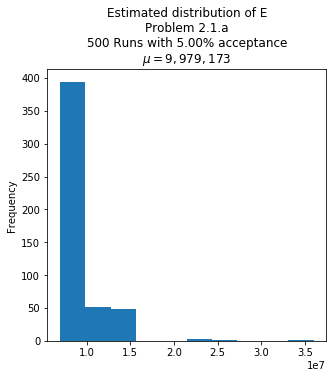

In [178]:
fig,ax = plt.subplots(figsize=(5,5))
df_21a["Youngs Modulus"].plot(kind="hist",ax=ax)
ax.set_title(f"Estimated distribution of E\nProblem 2.1.a\n500 Runs with {np.sum(df_21a['accepted'])/500.0*100:,.2f}% acceptance\n$\mu={df_21a['Youngs Modulus'].mean():,.0f}$")

#### b. We have measured the displacemetn of node 2 in the three directions as $[0.1128,,-0.3636,-0.0577]$.  Estimate the elastic modulus using this observation.

In [179]:
datas_21b = {(1,0):0.1128,(1,1):-0.3636,(1,2):-0.0577} #indices,value

In [180]:
df_21b = ProblemTwo(500,datas_21b)

 [████████████████████████████████████████████████████████████] 500/500 [00:29<00:00, 0.06s/it]

Text(0.5, 1.0, 'Estimated distribution of E\nProblem 2.1.b\n500 Runs with 6.00% acceptance\n$\\mu=9,679,935$')

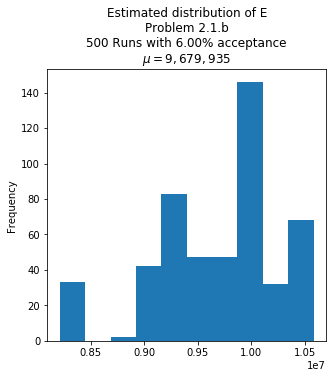

In [181]:
fig,ax = plt.subplots(figsize=(5,5))
df_21b["Youngs Modulus"].plot(kind="hist",ax=ax)
ax.set_title(f"Estimated distribution of E\nProblem 2.1.b\n500 Runs with {np.sum(df_21b['accepted'])/500.0*100:,.2f}% acceptance\n$\mu={df_21b['Youngs Modulus'].mean():,.0f}$")

#### c. We have measured the displacement of node 1 as $[0.1084,-0.3474,-0.0286]$, and the displacement of node 2 as $[0.1128,-0.3636,-0.0577]$.

In [184]:
datas_21c = {(0,0):0.1084,(0,1):-0.3474,(0,2):-0.0286,(1,0):0.1128,(1,1):-0.3636,(1,2):-0.0577} #indices,value
df_21c = ProblemTwo(2000,datas_21c)

 [████████████████████████████████████████████████████████████] 2000/2000 [01:51<00:00, 0.06s/it]

Text(0.5, 1.0, 'Estimated distribution of E\nProblem 2.1.c\n2000 Runs with 6.00% acceptance\n$\\mu=9,616,612$')

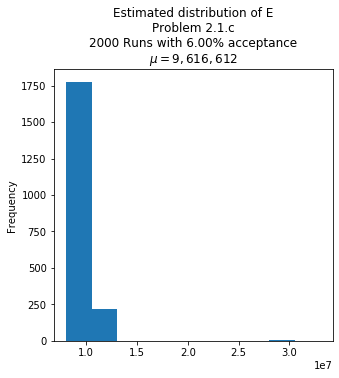

In [185]:
fig,ax = plt.subplots(figsize=(5,5))
df_21c["Youngs Modulus"].plot(kind="hist",ax=ax)
ax.set_title(f"Estimated distribution of E\nProblem 2.1.c\n2000 Runs with {np.sum(df_21c['accepted'])/2000.0*100:,.2f}% acceptance\n$\mu={df_21c['Youngs Modulus'].mean():,.0f}$")

Compare and discuss the results pertaining to these cases.

As may be expected, the inclusion of more data points appears to, for lack of a better word, "reveal" more information about the posterior distribution of the observations.  The distribution becomes more spread out, in part I suspect reflecting the increased acceptance rate which more points appears to allow.  This increased acceptance rate is likely because of my choice to add liklihood functions, which very much may not be defensible.  However, multiplying liklihood functions resulted in all points being rejected, perhaps reflecting an error in my liklihood function such as not utilizing log liklihood.  This suprisingly results in a substantial shift in the mean for part c, while the mode of the distribution does appear closer to the value found in parts a and b.  However, this value becomes much closer to the value in the subsequent part, suggesting that perhaps the fit is becomming better as more data is added. This is intuitive and what one would expect, however I am surprised how dramatic the difference is going from two to three observations, with relatively smaller additional change to mean going to 150 observations in Problem 2.2 with all 50 tests utilized. 

### Part 2.2

Now, consider a number of 50 truss structures are made and tested and node 2 displacements in $x$, $y$, and $z$ directions are recorded for each experiment.  The file 'observations.txt' includes the recorded displacements.  Assuming a uniform prior for the elastic modulus in the same range ($[5e6,5e7]$), estimate the posterior pdf for the elastic modulus given these observations.  In particular, calculate three different posterior pdfs for three difference cases where 5, 20, and finally all 50 tests are used.  Compare and discuss the results.

In [188]:
observations = "assignment4/observations.txt"

In [189]:
observations = pd.read_csv(observations,header=None)
observations.columns = ["x","y","z"]

In [190]:
# this is not working because it is overwriting the key!  Fix that and then run for 5,20, and 50 runs

In [201]:
# liklihood function- updated because the previous key result would not work
def f_errorCheck(elasticModulus,yActual,dataQueryKey):
    F,U,R = predict_y(elasticModulus)
    print(dataQueryKey)
    dataQueryKey = dataQueryKey[1]
    prediction = U[dataQueryKey[0]][dataQueryKey[1]] # kludge
    errorDist = stats.norm(loc=prediction,scale=0.01)
    p = errorDist.pdf(yActual)
    return p

In [246]:
# This function calculates the liklihood (non-log) of an indvidual observation
def π_Liklihood(ϵ,yActual,dataQueryKey):
    F,U,R = predict_y(ϵ)
    prediction = U[dataQueryKey[0]][dataQueryKey[1]]
    errorDist = stats.norm(loc=prediction,scale=0.01)
    p = errorDist.pdf(yActual)
    return p

In [247]:
datas_22 = {}
for i,row in observations.iterrows():
    datas_22[(i,(1,0))] = row["x"]
    datas_22[(i,(1,1))] = row["y"]
    datas_22[(i,(1,2))] = row["z"]

First five tests

In [248]:
datas_22_5 = {k:v for k,v in datas_22.items() if k[0] < 5}

In [249]:
df_22_5 = ProblemTwo(500,datas_22_5)

 [████████████████████████████████████████████████████████████] 500/500 [00:28<00:00, 0.06s/it]

Text(0.5, 1.0, 'Estimated distribution of E\nProblem 2.2 (5 tests)\n500 Runs with 6.80% acceptance\n$\\mu=9,650,158$')

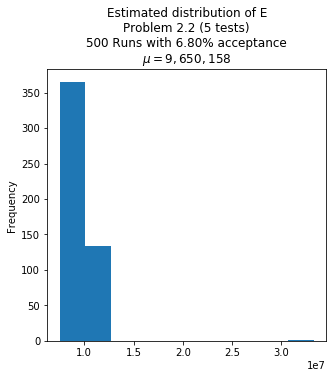

In [250]:
fig,ax = plt.subplots(figsize=(5,5))
df_22_5["Youngs Modulus"].plot(kind="hist",ax=ax)
ax.set_title(f"Estimated distribution of E\nProblem 2.2 (5 tests)\n500 Runs with {np.sum(df_22_5['accepted'])/500.0*100:,.2f}% acceptance\n$\mu={df_22_5['Youngs Modulus'].mean():,.0f}$")

First 20 tests

In [251]:
datas_22_20 = {k:v for k,v in datas_22.items() if k[0] < 20}

In [252]:
df_22_20 = ProblemTwo(500,datas_22_20)

 [████████████████████████████████████████████████████████████] 500/500 [00:28<00:00, 0.06s/it]

Text(0.5, 1.0, 'Estimated distribution of E\nProblem 2.2 (20 tests)\n500 Runs with 7.20% acceptance\n$\\mu=9,971,324$')

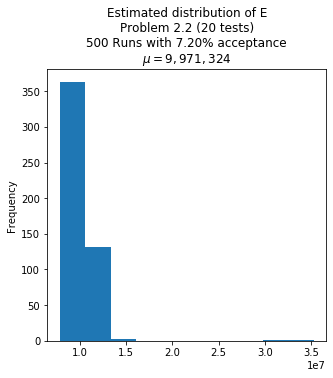

In [253]:
fig,ax = plt.subplots(figsize=(5,5))
df_22_20["Youngs Modulus"].plot(kind="hist",ax=ax)
ax.set_title(f"Estimated distribution of E\nProblem 2.2 (20 tests)\n500 Runs with {np.sum(df_22_20['accepted'])/500.0*100:,.2f}% acceptance\n$\mu={df_22_20['Youngs Modulus'].mean():,.0f}$")

All data points

In [254]:
df_22 = ProblemTwo(500,datas_22)

 [████████████████████████████████████████████████████████████] 500/500 [00:28<00:00, 0.06s/it]

Text(0.5, 1.0, 'Estimated distribution of E\nProblem 2.2 (50 tests)\n500 Runs with 8.80% acceptance\n$\\mu=10,122,517$')

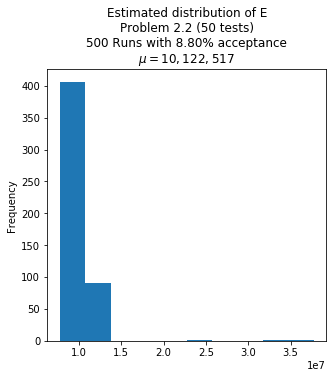

In [255]:
fig,ax = plt.subplots(figsize=(5,5))
df_22["Youngs Modulus"].plot(kind="hist",ax=ax)
ax.set_title(f"Estimated distribution of E\nProblem 2.2 (50 tests)\n500 Runs with {np.sum(df_22['accepted'])/500.0*100:,.2f}% acceptance\n$\mu={df_22['Youngs Modulus'].mean():,.0f}$")

In [256]:
E = df_22["Youngs Modulus"].mean()
D = Data(E)
F,U,R = ST(D)

In [257]:
U

array([[ 0.11176057, -0.3446703 , -0.04492179],
       [ 0.10553089, -0.34372473, -0.051526  ],
       [-0.00469588,  0.01744012,  0.06072176],
       [ 0.01152594,  0.01700451,  0.05595775],
       [-0.01537616,  0.02246016, -0.12407298],
       [ 0.02384497,  0.02219463, -0.12008503],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

Text(0.5, 1.0, 'Problem 2.2\nPredicted vs observed displacements at node 2')

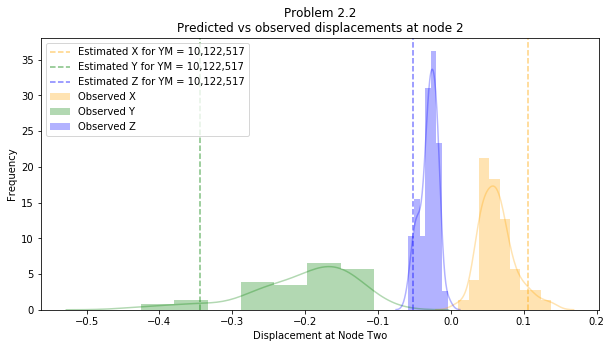

In [258]:
fig,ax = plt.subplots(figsize=(10,5))
kwargs = {'alpha':0.3}
sns.distplot(observations["x"],ax=ax,label="Observed X",hist_kws=kwargs, kde_kws=kwargs,color="orange")
sns.distplot(observations["y"],ax=ax,label="Observed Y",hist_kws=kwargs, kde_kws=kwargs,color="green")
sns.distplot(observations["z"],ax=ax,label="Observed Z",hist_kws=kwargs, kde_kws=kwargs,color="blue")
ax.axvline(U[1][0],label=f"Estimated X for YM = {E:,.0f}",ls="--",alpha=0.5,color="orange")
ax.axvline(U[1][1],label=f"Estimated Y for YM = {E:,.0f}",ls="--",alpha=0.5,color="green")
ax.axvline(U[1][2],label=f"Estimated Z for YM = {E:,.0f}",ls="--",alpha=0.5,color="blue")
ax.legend(loc="upper left")
ax.set_xlabel("Displacement at Node Two")
ax.set_ylabel("Frequency")
ax.set_title("Problem 2.2\nPredicted vs observed displacements at node 2")